In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,3)
plt.rcParams["font.size"] = 20.0

# Solving the wave equation in Python

Francesco Turci

25 March 2024

# A concrete problem

A single clap of our hands compresses the air locally and generates a longitudinal wave propagating through the air: **a sound wave**.


<div class="alert alert-block alert-success">
<b>Can we model sound propagation using the numerical tools that we know? </b>
</div>

# The wave equation

The wave equation models the space and time behaviour of a field $u(\vec{r},t)$


$$\dfrac{\partial^2 u}{\partial t^2}=c^2 \nabla^2 u$$

where the symbol $\nabla^2$ ( _nabla squared_) corresponds to the sum of **second derivatives in the Cartesian spatial dimensions**.


The constant $c$ is the **wave velocity**.

# The wave equation

The wave equation models the space and time behaviour of a field $u(\vec{r},t)$.

For example, in three  dimensions, the wave equation reads

$$\dfrac{\partial^2 u(x,y,z,t)}{\partial t^2}=c^2 \left(\dfrac{\partial^2 u(x,y,z,t)}{\partial x^2}+ \dfrac{\partial^2 u(x,y,z,t)}{\partial y^2}+\dfrac{\partial^2 u(x,y,z,t)}{\partial z^2} \right)$$

The constant $c$ is the **wave velocity**.

It is a **second-order, linear partial differential equation**. To be solved, it requires **two initial conditions**:

$$
\begin{align}u(x,y,z,0)&= I(x,y,z)\\
\partial_t u(x,y,z,0)&=0 
\end{align}
$$

where the function $I(x,y,z)$ is the initial shape of the signal. 

**Boundary conditions** are also needed: we will see them later.


In our acoustic problem, the field of interest is the **pressure** $p$. In general it depends on the three spatial coordinates as well as time.

For the moment, however, let us simplify the description and only consider propagation in a **single spatial dimension** $x$.





$$\dfrac{\partial^2 p(x,t)}{\partial t^2}=c^2 \dfrac{\partial^2 p(x,t)}{\partial x^2},\quad 
p(x,0)= I(x),\quad
\partial_t p(x,0)=0 
$$

Here $c$ is the sound velocity, and it depends on the elastic modulus and the density of air.

## Thinking algorithmically

The pressure in the wave equation is defined everywhere and for all times. 

Yet, on the computer, we can only deal with **discrete** amounts of data in space and time.

To solve our problem, the following recipe will be useful:

<div class="alert alert-block alert-info"> <b>Recipe</b> <br>
    1 - Discretise all the field $p$ and its <b>derivatives</b> (space and time)<br>
    2 - Approximate the <b>time evolution</b> <br>
    3 - From a given initial condition $p_0$, <b>recursively</b> update the pressure field <br>
</div>

## Discretisation

- We sample the field at fixed positions $x_0\dots x_N$ separated by a spacing $\Delta x$, with $L = N\Delta x$
- We sample the field at discrete times $t_0\dots t_n$ separated by an interval $\Delta t$

<center>
    <img src="gridV.png" alt-text="grid" style="height: 350px"> 
</center>

This means that $p$ is defined over a **grid in space and time**. 

Grids are easily represented as **arrays** on a computer. 

We have 1+1 dimensions, so we want the pressure to be an **array** `p` such that **rows are space and columns are time**. We refer to this array with the notation $p_i^n$ , where $n$ is the time index and $i$ is the spatial index.


But how do we deal with the derivatives?

### Discretisation: first derivative by finite differences

By definition

$$\dfrac{\partial p(x,t)}{\partial x}= \lim_{\Delta x\rightarrow 0 }\dfrac{p(x+\Delta x)-p(x)}{\Delta x}$$

On the computer, instead of taking the limit, we can just take a _small_ $\Delta x$, so that 

$$\dfrac{\partial p(x,t)}{\partial x}\approx\dfrac{p(x+\Delta x,t)-p(x,t)}{\Delta x}$$

Using our simplified array notation we have

$$\dfrac{\partial p(x_i,t_n)}{\partial x}\approx\dfrac{p_{i+1}^{n}-p_{i}^{n}}{\Delta x}$$

Yet, for the wave equation, we need the **second derivative**.

### Discretisation: second derivative

We can very simply think of the second derivative as the change in the first derivative between $x-\Delta x$ and $x+\Delta x$

$$
\dfrac{\partial^2 p(x,t)}{\partial x^2}\approx\dfrac{\dfrac{p(x+\Delta x,t)-p(x,t)}{\Delta x}-\dfrac{p(x,t)-p(x-\Delta x,t)}{\Delta x}}{\Delta x}\\
$$

$$= \frac{p(x+\Delta x,t)-2 p(x,t)+p(x-\Delta x,t)}{\Delta x^2} 
$$

This is a simple recipe which requires the knowledge of the pressure at **$x$ and two points around $x$**.

An identical argument can be made for the **time derivative**.

Using the array notation, we finally have

$$
\begin{align}
\dfrac{\partial^2 p(x_i,t_n)}{\partial x^2}&\approx\dfrac{p_{i+1}^{n}-2 p_{i}^n+p_{i-1}^{n}}{\Delta x^2}  \\
\dfrac{\partial^2 p(x_i,t_n)}{\partial t^2}&\approx \dfrac{p_i^{n+1}-2p_i^{n}+p_i^{n-1}}{\Delta t^2}
\end{align}
$$

We can plug this in the wave equation to get

$$
\begin{equation}
\boxed{\dfrac{p_i^{n+1}-2p_i^{n}+p_i^{n-1}}{\Delta t^2}=c^2\dfrac{p_{i+1}^{n}-2 p_{i}^n+p_{i-1}^{n}}{\Delta x^2}}
\end{equation}
$$



### Discretised wave equation

We can rearrange the previous equation as 

$$
\begin{equation}
p_i^{n+1}-2p_i^{n}+p_i^{n-1}=\alpha^2 \left( p_{i+1}^{n}-2 p_{i}^n+p_{i-1}^{n}\right)
\end{equation}
$$

where $\alpha$ is the **Courant number** $\alpha=c\Delta t/\Delta x$. 

It is a **non-dimensional number** that we want to be _small_. It illustrates that space and time discretisations are **linked**.



### Recursion

For later iterations, we need an **update rule**.  From

$$
\begin{equation}
p_i^{n+1}-2p_i^{n}+p_i^{n-1}=\alpha^2 \left( p_{i+1}^{n}-2 p_{i}^n+p_{i-1}^{n}\right)
\end{equation}
$$

we can rearrange the terms so that we express the term $p_i^{n+1}$ (the wave **in the future** at step `n+1`) as a function of the other terms

$$
\begin{equation}
\boxed{p_i^{n+1}=\alpha^2 \left( p_{i+1}^{n}-2 p_{i}^n+p_{i-1}^{n}\right)+2p_i^{n}-p_i^{n-1}}
\end{equation}
$$

This is our key result. It can be readily **implemented**.

### Initial conditions

The first initial condition becomes

$$p_i^0= I(x_i)$$


while $\partial_t p(x,0)=0$  becomes  

$$\partial_t p(x,0)\approx(p_i^{1}-p_i^0)/\Delta t\rightarrow p_i^0= p_i^1$$


This means that:
- we can choose an initial shape for the wave (for example a localised signal)
- we can set this both for the 0th and 1st iteration


## Implementation 

Algorithm:

1. Set the initial conditions
2. Update the pressure at step n+1
3. Enforce the boundary conditions

The **boundary conditions** arise because we  simulate a finite domain. There are many options (periodic, reflective, constant).

Here we decide to take constant (Dirichlet) boundary conditions, such that $p_0^n=p_{-1}^n=0$, where the index $-1$ stands for the **last element of the array** (Python convention).

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

### Initialisation

- Choose a domain of length `L` divided in `N` intervals and a small Courant `alpha` parameter to determine the timestep
- Construct an array `p` with `N+1` rows (space) and 3 columns for the **past, present and future** times.
- Choose a simple initial condition, with a **localised pressure peak**

In [3]:
def initialise(N=1000, L=128.0, alpha=0.1,peak=1,c=1):
    dx = L/N
    dt = alpha/c*dt
    ...
    
    return p,alpha,dx,dt

In [4]:
def initialise(N=1000, L=128.0, alpha=0.1,peak=1.0,c=1):
    dx = L/N
    dt = alpha/c*dx
    # define pressure array
    p = np.zeros((N+1,3)) # N+1 space points, and 3 (past/present/future) time points
    
    # initial conditions
    #     1:pressure peak
    p[N//2-1:N//2+2,0] = peak
    #     2: dpdt=0
    p[:,1] = p[:,0] #0th time profile equal to 1st time profile
    return p,alpha,dx,dt

### Time evolution
We then apply the **recursion formula**

$$
\begin{equation}
\boxed{p_i^{n+1}=\alpha^2 \left( p_{i+1}^{n}-2 p_{i}^n+p_{i-1}^{n}\right)+2p_i^{n}-p_i^{n-1}}
\end{equation}
$$

initially in a naive way (an explicit `for-loop`). 

**Exercise:** _find a simple way to use_ `numpy`_'s vectorisation to avoid the for loop._

In [5]:
def naive_evolve(p,alpha,n=1):
    for i in range(1,p.shape[0]-1):
        p[i,n+1] =  alpha**2*...
        
    #     forget the past
    p[:,n-1] = p[:,n] 
    # swap present with future
    p[:,n] = p[:,n+1]
    

$$
\begin{equation}
\boxed{p_i^{n+1}=\alpha^2 \left( p_{i+1}^{n}-2 p_{i}^n+p_{i-1}^{n}\right)+2p_i^{n}-p_i^{n-1}}
\end{equation}
$$

In [8]:
def naive_evolve(p,alpha,n=1):
    for i in range(1,p.shape[0]-1):
        p[i,n+1] =  alpha**2*(p[i+1,n]-2*p[i,n]+p[i-1,n])+2*p[i,n]-p[i,n-1]
        
    #     forget the past
    p[:,n-1] = p[:,n] 
    # swap present with future
    p[:,n] = p[:,n+1]
        

### Boundary conditions

We finally have the boundary conditions, which we choose to be trivial and constant

In [6]:
def boundaries(p):
    p[0,:] = 0
    p[-1,:] = 0

We can then put everything toghether

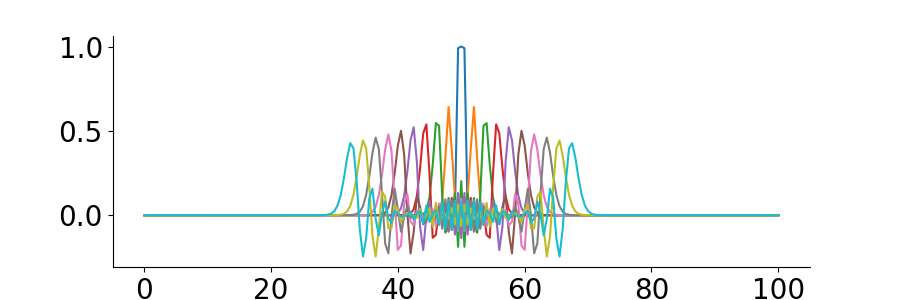

In [9]:
L, N, tmax = 100.0, 200, 20.0
p, alpha, dx, dt = initialise(N, L, alpha=0.1)
x = np.arange(N+1)*dx
fig, ax = plt.subplots()
# time evolution
for iteration in range(int(tmax/dt)):
    naive_evolve(p,alpha)
    boundaries(p)
    if iteration%int(tmax/dt/10)==0: ax.plot(x,p[:,1])      
plt.show()

## A simple animation

We can use `FuncAnimation` from `matplotlib` to produce a basic animation.

In [19]:
plt.close('all')

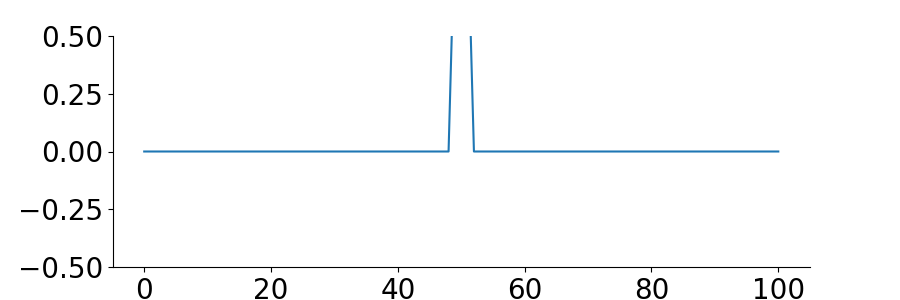

In [18]:
from matplotlib.animation import FuncAnimation
L, N = 100.0, 100
p, alpha, dx, dt = initialise(N, L,alpha=0.1)
x = np.arange(N+1)*dx
fig, axis = plt.subplots()
line, = axis.plot(x,p[:,1])
axis.set_ylim(-0.5,0.5)
def update(frame):
    """Update the pressure field and its plot"""
    naive_evolve(p,alpha)
    boundaries(p)
    line.set_ydata(p[:,1])
    return line,
animation = FuncAnimation(fig, update,  frames=range(1000),interval=2,repeat=False,blit=True)

## Testing

An essential component of good code are **tests**.

We can check the correctness of our solution by comparing it to a known **analytical** results.

Here, the simplest option is to carefully choose an initial condition compatible with the boundaries to have closed form solution. 

In this case, **standing waves** are a good solution

$$p(x,t) = A\sin\left(\dfrac{\pi x}{L}\right)\cos\left(\dfrac{\pi c t}{L}\right) $$




So, we simply modify the initalisation function to start from a suitable sine function

In [ ]:
def initialise_standing(N=1000, L=128.0, alpha=0.1,c=1, amplitude=1):
    dx = L/N
    dt = alpha/c*dx
    p = np.zeros((N+1,3))
    x = np.arange(N+1)*dx
    #     standing wave
    p [:,0] = amplitude*np.sin(np.pi/L*x)
    # initial condition    
    p[:,1] = p[:,0]
    return p,alpha,dx,dt,c

The bulk of the code remains essentially the same (and could be easily transformed into a `pytest` function)

In [ ]:
plt.close('all')

L, N, tmax = 100.0, 60, 20.0
p, alpha, dx, dt, c = initialise_standing(N, L,alpha=0.1)
x = np.arange(N+1)*dx 
fig_test, ax_test = plt.subplots()

for iteration in range(int(tmax/dt)):
    naive_evolve(p,alpha)
    boundaries(p)
    if iteration%int(tmax/dt/10)==0: 
        ax_test.plot(x,p[:,1]) # plotting the pressure profile
        theory = np.sin(np.pi/L*x)*np.cos(np.pi/L*c*iteration*dt) #  plotting the analytical result with black dashes
        ax_test.plot(x,theory, '--k', alpha=0.5)
plt.xlim(0,L)
plt.show()

print(f"Final mean square error is {np.mean((theory-p[:,1])**2)} ")

## Time profile

We started with a simple experiment recording the waveform in time. Can we approximate it?

Can just go back to our spike pulse and look at the pressure field at some distance from the origin of the signal over time.



In [ ]:
L, N, tmax = 100.0, 200, 60.0
p, alpha, dx, dt = initialise(N, L)
distance = int((L*0.5)-(L*0.1))
p_t = []

fig,ax = plt.subplots()
for iteration in range(int(tmax/dt)):
    naive_evolve(p,alpha)
    boundaries(p)
    p_t .append(p[distance,1])
ax.plot(np.arange(0,tmax,dt),p_t)
plt.xlabel('time [a.u.]'), plt.ylabel("p(distance,t) [a.u]")

## Conclusions

We have seen an implementation of the **finite difference** method to solve the wave equation in one spatial dimension.

You can find this notebook at https://github.com/FTurci/Waves

A web application is also available [here](https://one-d-waves-fbfa3e091dea.herokuapp.com/src)

<img src="qr.png" alt="qr-code" style="width: 300px; height: 300px;">

📕 Further reading: check the *Wave equations* chapter of Langtangen & Linge,  *Finite Difference Computing with PDEs. A Modern Software Approach* (Springer International Publishing, 2017).